# CV Assignment - Code

## Introduction and Setup
This colab worksheet provides a starting point for the computer vision assignment. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#import sys
#sys.path.append('/content/drive/My Drive/University/Year-2/CV Notebooks/Assignment/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls '/content/drive/MyDrive/University/Year-2/CV-Notebooks/Assignment/Data'

examples.npz  test_images.npz  training_images.npz


In [3]:
#Imports
import numpy as np
import torch as nn
import matplotlib.pyplot as plt
import cv2 
import sklearn as sk
import torch
from sklearn.mixture import GaussianMixture
from google.colab.patches import cv2_imshow
from sklearn.linear_model import LinearRegression
import numpy as np
!pip install PyMaxFlow
import maxflow

### Model Selection/Loading

In [ ]:
Final_Model = 'classifier.pt'
path = F"/content/gdrive/My Drive/University/Year-2/CV-Notebooks/Assignment/{Final_Model}" 
torch.save(model1.state_dict(), path)

In [ ]:
Model_NoProc = 'classifier.pt'
path = F"/content/gdrive/My Drive/University/Year-2/CV-Notebooks/Assignment/{model_save_name}"
model.load_state_dict(torch.load(path))

### Data Loading

In [4]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.
!wget "https://sussex.box.com/shared/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz" -O training_images.npz
#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz

--2021-05-19 22:08:13--  https://sussex.box.com/shared/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Resolving sussex.box.com (sussex.box.com)... 107.152.29.197
Connecting to sussex.box.com (sussex.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz [following]
--2021-05-19 22:08:13--  https://sussex.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz [following]
--2021-05-19 22:08:13--  https://sussex.app.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 107.152.29.201
Connecting to sussex.app.box.com (sussex.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

In [5]:
# Load the data using np.load
training_images = np.load('training_images.npz', allow_pickle=True)
test_images = np.load('test_images.npz', allow_pickle=True)
example_images = np.load('examples.npz', allow_pickle=True)


# Extract the images
train_img = training_images['images']
train_pts = training_images['points']

test_img = test_images['images']

ex_img = example_images['images']


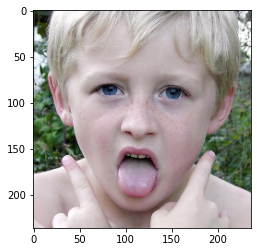

In [6]:
#Example Random Image from Training Data
plt.imshow(train_img[np.random.randint(0, train_img.shape[0]),...])
plt.show()

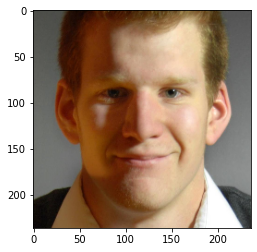

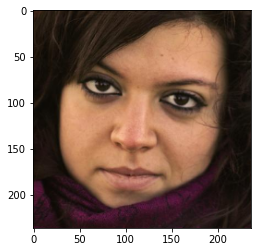

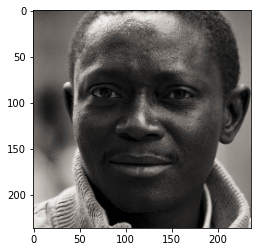

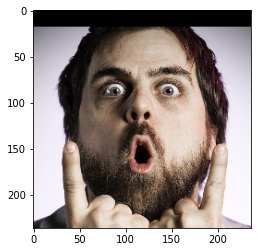

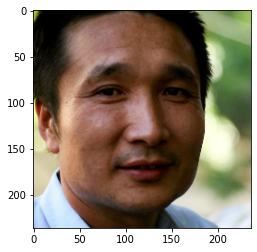

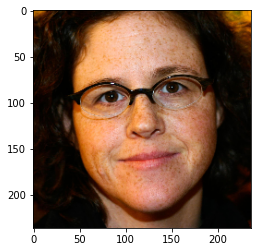

In [7]:
for i in range(len(ex_img)):
  plt.imshow(ex_img[i])
  plt.show()

### Helpful Functions

In [8]:
#This function was linked within colab and was not written by me. It was offered on the help forums for an issue, that made it unable
#to run and open large data sets. https://github.com/jupyter/notebook/issues/3935
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

## Pre-Processing

### Gaussian Blurring

In [9]:
gaussian_train = []
for i in range(len(train_img)): # looping through entire training image set
  gaussian_train.append(cv2.GaussianBlur(train_img[i], (5,5), 0)) #applying gaussian blur
gaussian_train_1 = np.array(gaussian_train)
gaussian_train_1.shape #shape of array - important for latter image flattening

(2811, 236, 236, 3)

In [10]:
gaussian_test = []
for i in range(len(test_img)): # looping through entire test image set
  gaussian_test.append(cv2.GaussianBlur(test_img[i], (5,5), 0)) #applying gaussian blur
gaussian_test_1 = np.array(gaussian_test)
gaussian_test_1.shape  #shape of array - important for latter image flattening

(554, 236, 236, 3)

### Adding Brightness

In [15]:
#brightness function - using color conversion to change brightness channels
def brightness(img, value=35):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
#changing brightness channels
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR) #return to old colour
    return img

In [16]:
bright_train = []
for i in range(len(gaussian_train_1)):
  bright_train.append(brightness(gaussian_train_1[i],value = 25)) #applying brightness function to training set
bright_train_1 = np.array(bright_train)
bright_train_1.shape    

(2811, 236, 236, 3)

In [17]:
bright_test = []
for i in range(len(gaussian_test_1)):
  bright_test.append(brightness(gaussian_test_1[i],value = 25)) #applying brightness function to test set
bright_test_1 = np.array(bright_test)
bright_test_1.shape   

(554, 236, 236, 3)

## Feature Computation

### ORB

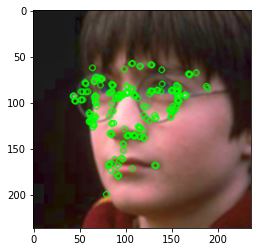

In [14]:
#Development of ORB
#Defining two lists to add results of orb calculation/manipulation 
orb_a = [] 
orb_b = []
for i in range(len(bright_train_1)):
  orb = cv2.ORB_create() # creating orb object

  kp_detect = orb.detect(bright_train_1[i],None) # detecting keypoints

  kp, des = orb.compute(bright_train_1[i], kp_detect) #computing descriptors and keypoints

  orb_a.append(cv2.drawKeypoints(bright_train_1[i], kp, None, color=(0,255,0), flags=0)) # appended to first list
  orb_b.append(des) # as we seek descriptos we append them to the second list
orb_img = np.array(orb_a) #change list to numpy array 
#orb_des = np.asarray([np.asarray(orb_b) for des in orb_b])
#orb_des = np.array([np.array(orb_b, dtype=object) for des in orb_b])
#orb_des =  np.array(orb_b, dtype=object)
plt.imshow(orb_img[np.random.randint(0, orb_img.shape[0]),...])
plt.show()

In [18]:
#descriptor function
def descriptors(img):
  des_list = []

  #repeating orb steps within loop to identify keypoin descriptor
  #these are then appended to a list
  for i in img:
    kp = orb.detect(i,None)
    kp, des = orb.compute(i, kp)
  
    img_kp = np.zeros_like(i) #convert img input to np.zeros
    cv2.drawKeypoints(i, kp, img_kp, flags=4) #drawkeypoints with new image to prevent wrong shape from appearing
    des_list.append(img_kp)
  return des_list
#testing shape and output
#test = descriptors(bright_train_1)
#print(type(test))
#print(len(test))

In [19]:
#looping through training images to generate descriptors
descriptions_list=[]
for i in bright_train_1:
  descriptions_list.append(descriptors(i))
#print(len(descriptions_list))
descr_pts = np.array(descriptions_list)
#outputting and testing shape
print(descr_pts.shape)

(2811, 236, 236, 3)


## Data Flattening

### Test Data, Train Data and Train Point flattening
For additional pre-processing and feature descriptor model

In [20]:
#data flattening for training images (pre-processed)
flat_img2 = []
for i in range(len(bright_train_1)):
  flat_img2.append(bright_train_1[i].flatten())
flat_img_2 = np.array(flat_img2)
flat_img_2.shape  

(2811, 167088)

In [21]:
#data flattening for training points (pre-processed)
flat_pts2 = []
for i in range(len(train_pts)):
  flat_pts2.append(train_pts[i].flatten())
flat_pts_2 = np.array(flat_pts2)
flat_pts_2.shape

(2811, 92)

In [22]:
#data flattening for training points (pre-processed)
flat_descr = []
for i in range(len(descr_pts)):
  flat_descr.append(descr_pts[i].flatten())
flat_descr_1 = np.array(flat_descr)
flat_descr_1.shape

(2811, 167088)

In [23]:
#data flattening for test images (pre-processed)
flat_test2 = []
for i in range(len(bright_test_1)):
  flat_test2.append(bright_test_1[i].flatten())
flat_test_2 = np.array(flat_test2)
flat_test_2.shape  

(554, 167088)

### Test Data, Train Data and Train Point flattening
For model without additional pre-processing

In [24]:
#data flattening for training images (not pre-processed)
flat_img = []
for i in range(len(train_img)):
  flat_img.append(train_img[i].flatten())
flat_img_1 = np.array(flat_img)
flat_img_1.shape  

(2811, 167088)

In [25]:
#data flattening for training points (not pre-processed)
flat_pts = []
for i in range(len(train_pts)):
  flat_pts.append(train_pts[i].flatten())
flat_pts_1 = np.array(flat_pts)
flat_pts_1.shape


(2811, 92)

In [26]:
#data flattening for test images (not pre-processed)
flat_test = []
for i in range(len(test_img)):
  flat_test.append(test_img[i].flatten())
flat_test_1 = np.array(flat_test)
flat_test_1.shape  

(554, 167088)

## Example Data flattening

In [27]:
#data flattening for example images - for later use in extra tasks
ex_flat_img = []
for i in range(len(ex_img)):
  ex_flat_img.append(ex_img[i].flatten())
ex_fl_img = np.array(ex_flat_img)
ex_fl_img.shape  

(6, 167088)

## Model Creation

### Linear Regression (for not pre-processed data)
Without major pre-processing - just image flattening

In [28]:
#Linear regression
model = LinearRegression(normalize=True)
model.fit(flat_img_1,flat_pts_1)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [29]:
#prediction points
y_pred = model.predict(flat_test_1)
#print(y_pred)

In [30]:
model.score(flat_img_1,flat_pts_1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


1.0

### Unflattening Data

In [31]:
#unflattening data with reshape tool
train_set = flat_img_1.reshape([2811, 236, 236, 3])
pts_set = flat_pts_1.reshape([2811, 46, 2])
test_set = flat_test_1.reshape(554, 236, 236, 3)
pred_set = y_pred.reshape(554, 46, 2)

### Data Visualisation
Here's an example of how to display the images and their points

(236, 236, 3) (46, 2)


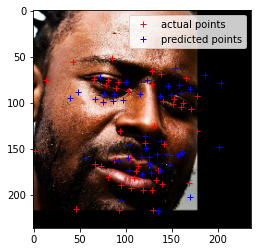

In [32]:
#visualisation of keypoints on random images
def visualise_all_pts(img, pts,pred_pts):
  print(img.shape, pts.shape)
  plt.imshow(img[0:])
  plt.plot(pts[:, 0], pts[:, 1], '+r',label='actual points')
  plt.plot(pred_pts[:, 0], pred_pts[:, 1], '+b',label='predicted points')
  plt.legend()
  plt.show()

idx = np.random.randint(0, train_set.shape[0])
idx_ = np.random.randint(0, test_set.shape[0])
visualise_all_pts(train_set[idx], pts_set[idx],pred_set[idx_])

(236, 236, 3) (46, 2)


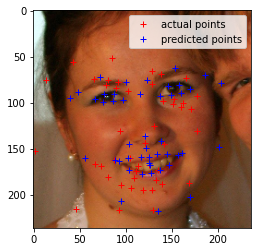

In [33]:
#On test images
visualise_all_pts(test_set[idx_], pts_set[idx],pred_set[idx_])

Euclidian Distance

In [34]:
#euclidian distance calculation
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  #import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))
euclid_dist(pred_set,pts_set[:554])

array([26.85997789, 24.65637976, 11.62525646, ..., 19.99087446,
       13.92829992, 15.00322505])

In [35]:
#average of euclidian distance
np.average(euclid_dist(pred_set,pts_set[:554]))

15.338435242815523

In [36]:
np.argmin((euclid_dist(pred_set,pts_set[:554])))

17699

In [37]:
np.argmax((euclid_dist(pred_set,pts_set[:554])))

22816

### Linear Regression (for pre-processed data)

In [38]:
#linear regression for pre-processed data
model1 = LinearRegression(normalize=True)
model1.fit(flat_img_2,flat_pts_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [39]:
#prediction points
y_pred3 = model1.predict(flat_descr_1)
#y_pred2 = model1.predict(flat_test_2)
#print(y_pred)

In [40]:
model1.score(flat_img_2,flat_pts_2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


1.0

### Unflattening Data (for pre-processed data)

In [41]:
#unflattening data for pre-processed data
train_set2 = flat_img_2.reshape([2811, 236, 236, 3])
pts_set2 = flat_pts_2.reshape([2811, 46, 2])
test_set2 = flat_test_2.reshape(554, 236, 236, 3)
pred_set2 = y_pred3.reshape(2811, 46, 2)

### Data Visualisation (for pre-processed data)

(236, 236, 3) (46, 2)


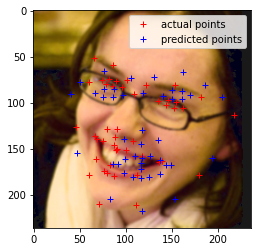

In [42]:
#visulaising points for pre processed data
def visualise_all_pts2(img2, pts2, pred_pts2):
  print(img2.shape, pts2.shape)
  plt.imshow(img2[0:])
  plt.plot(pts2[:, 0], pts2[:, 1], '+r',label='actual points')
  plt.plot(pred_pts2[:, 0], pred_pts2[:, 1], '+b',label='predicted points')
  plt.legend()
  plt.show()

idx2 = np.random.randint(0, train_set2.shape[0])
idx2_ = np.random.randint(0, test_set2.shape[0])
visualise_all_pts2(train_set2[idx2], pts_set2[idx2], pred_set2[idx2_])

(236, 236, 3) (46, 2)


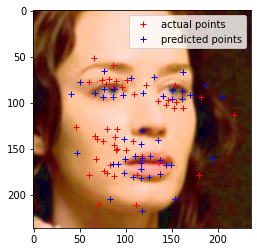

In [43]:
#On test set
visualise_all_pts2(test_set2[idx2_], pts_set2[idx2],pred_set2[idx2_])

In [44]:
#euclidian distance for "pre-processed" model
def euclid_dist2(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  #import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))
euclid_dist2(pred_set2,pts_set2[:129306])

array([ 2.78686595,  9.12708252,  8.76405852, ..., 17.86507812,
       11.7607528 , 12.18339629])

In [45]:
#average of "pre processed" model
np.average(euclid_dist2(pred_set2,pts_set2[:129306]))

11.146364922985299

In [46]:
np.argmin((euclid_dist2(pred_set2,pts_set2[:129306])))

60395

In [47]:
np.argmax((euclid_dist2(pred_set2,pts_set[:129306])))

73192

## Operation on test images 
handed in via csv file

In [48]:
#looping through test images to generate descriptors
test_descriptions_list=[]
for i in test_img:
  test_descriptions_list.append(descriptors(i))
#print(len(descriptions_list))
test_descr_pts = np.array(test_descriptions_list)
#outputting and testing shape
print(test_descr_pts.shape)

(554, 236, 236, 3)


In [49]:
#loop construct to reshape into numpy array
flat_test4 = []
for i in range(len(test_descr_pts)):
  flat_test4.append(test_descr_pts[i].flatten())
flat_test_4 = np.array(flat_test4)
flat_test_4.shape  

(554, 167088)

In [51]:
test_predictions2 = model1.predict(flat_test_4).reshape(554, 46, 2) 

In [52]:
def visualise_test_pts(img, pts):
 
    plt.imshow(img)
    plt.plot(pts[:, 0], pts[:, 1], '+r')
    plt.show()

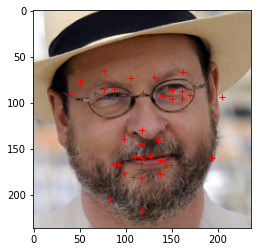

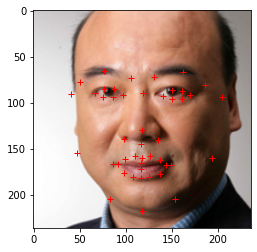

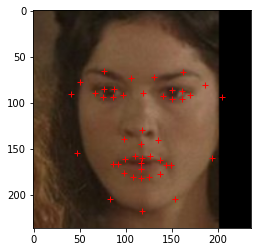

In [53]:
test = 3
for i in range(test):
    i = np.random.randint(0, test_img.shape[0])
    visualise_test_pts(test_img[i], test_predictions2[i])

**Prior testing - values not added to report**

In [57]:
test_features = descriptors(test_img)

In [61]:
flat_test3 = []
for i in range(len(test_features)):
  flat_test3.append(test_features[i].flatten())
flat_test_3 = np.array(flat_test3)
flat_test_3.shape  

(554, 167088)

In [66]:
test_predictions = model1.predict(flat_test_3).reshape(554, 46, 2) 

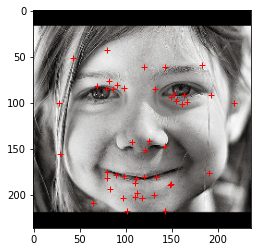

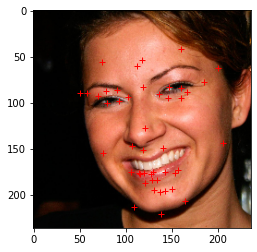

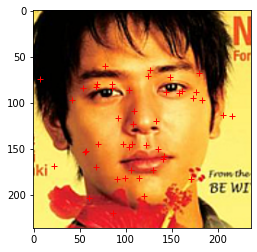

In [70]:
for i in range(test_img.shape[3]):
  visualise_test_pts(test_img[i], test_predictions[i])

### Exporting results

In [54]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [55]:
save_as_csv(test_predictions2,'/content/drive/MyDrive/University/Year-2/CV-Notebooks/Assignment/Data')

## Apply Model to Example Images





### Applying Model without pre-processing

In [89]:
ex_pred1 = model.predict(ex_fl_img)

In [90]:
ex_set1 = ex_fl_img.reshape([6, 236, 236, 3])
ex_pred_set1 = ex_pred1.reshape(6,46,2)

In [91]:
#visulaising points for not pre processed data
def visualise_ex_pts1(img, pts):
  print(img.shape, pts.shape)
  plt.imshow(img[0:])
  plt.plot(pts[:, 0], pts[:, 1], '+r',label='actual points')
  #plt.plot(pred_pts2[:, 0], pred_pts2[:, 1], '+b',label='predicted points')
  plt.legend()
  plt.show()

idex = np.random.randint(0, ex_set1.shape[0])
#visualise_ex_pts1(ex_set1[idex],ex_pred_set1[idex])

(236, 236, 3) (46, 2)


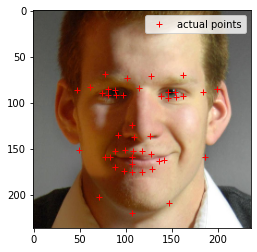

(236, 236, 3) (46, 2)


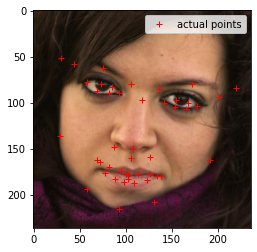

(236, 236, 3) (46, 2)


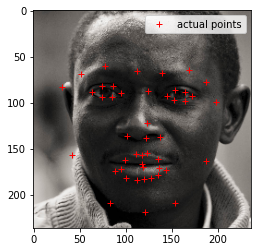

(236, 236, 3) (46, 2)


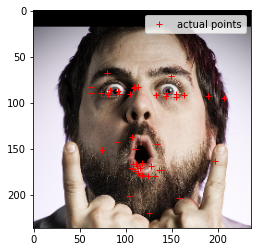

(236, 236, 3) (46, 2)


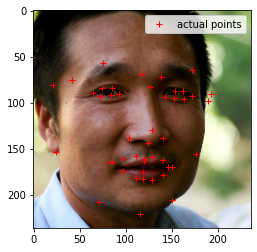

(236, 236, 3) (46, 2)


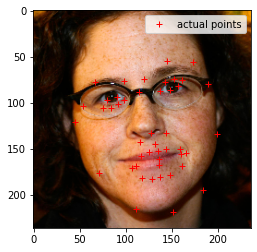

In [92]:
for i in range(ex_img.shape[0]):
    visualise_ex_pts1(ex_set1[i], ex_pred_set1[i])

In [ ]:
np.average(euclid_dist(pred_set,pts_set2[:554]))

In [ ]:
np.argmin((euclid_dist(pred_set,pts_set2[:554])))

In [ ]:
np.argmax((euclid_dist(pred_set,pts_set[:554])))

### Applying Model with pre-processing

In [56]:
#looping through test images to generate descriptors
ex_descriptions_list=[]
for i in ex_img:
  ex_descriptions_list.append(descriptors(i))
#print(len(descriptions_list))
ex_descr_pts = np.array(ex_descriptions_list)
#outputting and testing shape
print(ex_descr_pts.shape)

(6, 236, 236, 3)


In [57]:
#data flattening for example images 
ex_fleat2 = []
for i in range(len(ex_descr_pts)):
  ex_fleat2.append(ex_descr_pts[i].flatten())
ex_descr_flat2 = np.array(ex_fleat2)
ex_descr_flat2.shape  

(6, 167088)

In [58]:
ex_predx2 = model1.predict(ex_descr_flat2).reshape(6,46,2)

In [59]:
#visulaising points for not pre processed data
def visualise_ex_pts4(img, pts):
  print(img.shape, pts.shape)
  plt.imshow(img[0:])
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  #plt.plot(pred_pts2[:, 0], pred_pts2[:, 1], '+b',label='predicted points')
  plt.legend()
  plt.show()

#idex = np.random.randint(0, ex_set2.shape[0])

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


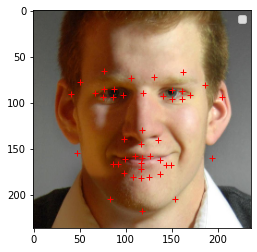

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


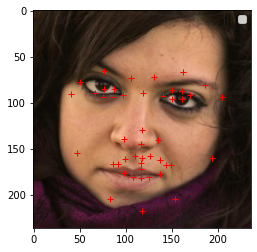

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


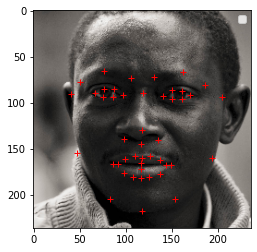

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


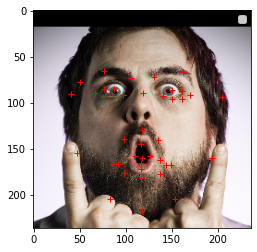

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


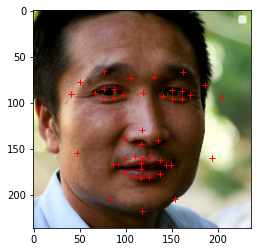

No handles with labels found to put in legend.


(236, 236, 3) (46, 2)


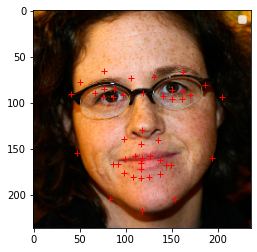

In [60]:
for i in range(ex_img.shape[0]):
    visualise_ex_pts4(ex_img[i], ex_predx2[i])

**Prior testing - values not added to report**

In [74]:
ex_features = descriptors(ex_img)

In [77]:
#data flattening for example images 
ex_fleat = []
for i in range(len(ex_features)):
  ex_fleat.append(ex_features[i].flatten())
ex_descr_flat = np.array(ex_fleat)
ex_descr_flat.shape  

(6, 167088)

In [79]:
ex_predx = model1.predict(ex_descr_flat).reshape(6,46,2)

In [ ]:
for i in range(ex_img.shape[0]):
    visualise_ex_pts4(ex_img[i], ex_predx[i])

## Extension Task

### Filters

In [61]:
#arggggghhhhhhhhh, captain
#pirare function - adds eye patch to example image
def pirate(img, pts):

    eye_patch = (int(pts[11][0]),int(pts[12][1]))

    img = cv2.circle(img, eye_patch, 25, (0,0,0), -1)
    plt.imshow(img)
    plt.show()

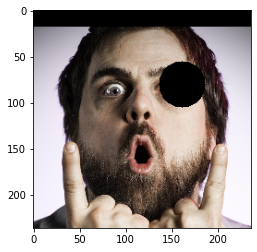

In [62]:
pirate(ex_img[3], ex_predx2[3])

### Segmentation

In [63]:
#creating mask - outline mask around image 
#grabcut is applied to this area and segments the image accordingly
def create_fg_mask(img):
  from matplotlib import patches
  fg_mask = np.zeros(img.shape[0:2], dtype=np.bool)

  pix_around_center = 80
  fg_mask[img.shape[0] // 2 - pix_around_center: img.shape[0] // 2 +pix_around_center, img.shape[1] // 2 - pix_around_center: img.shape[1] // 2 +pix_around_center] = True

  ax = plt.subplot(111)
  plt.imshow(img)
  
  rect = patches.Rectangle((img.shape[1] // 2 -pix_around_center, img.shape[0]//2 - pix_around_center), pix_around_center*2, pix_around_center*2, fill=False, lw=5, color='g')
  ax.add_patch(rect)
  plt.show()
  return fg_mask



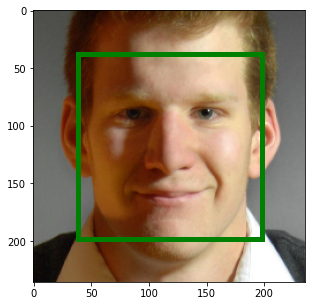

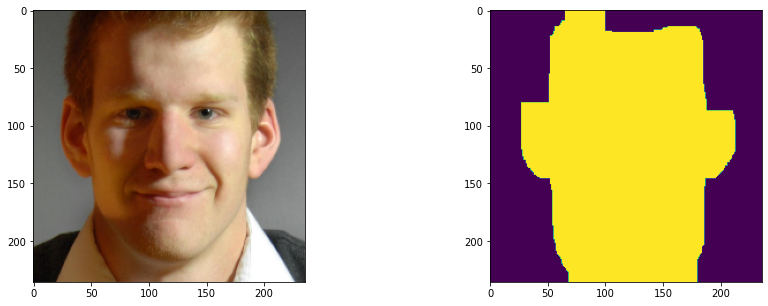

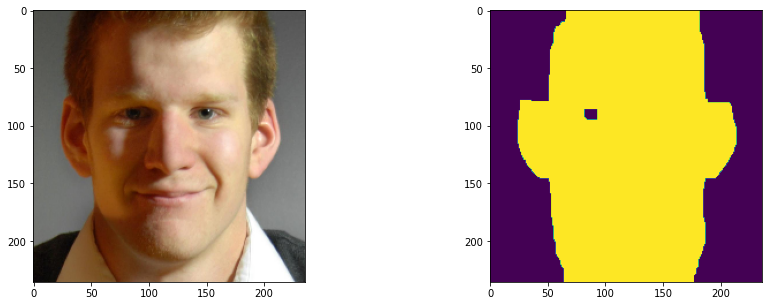

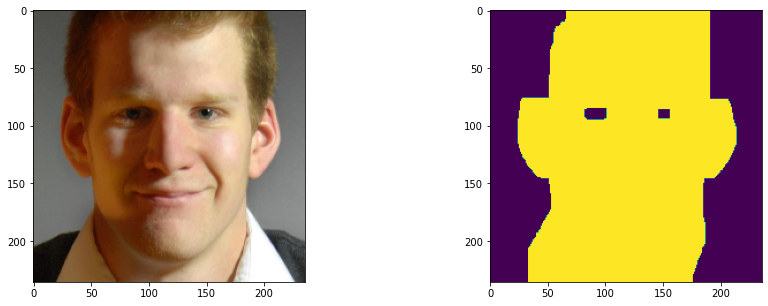

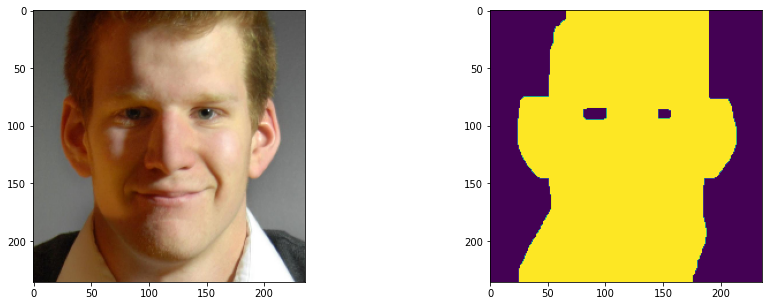

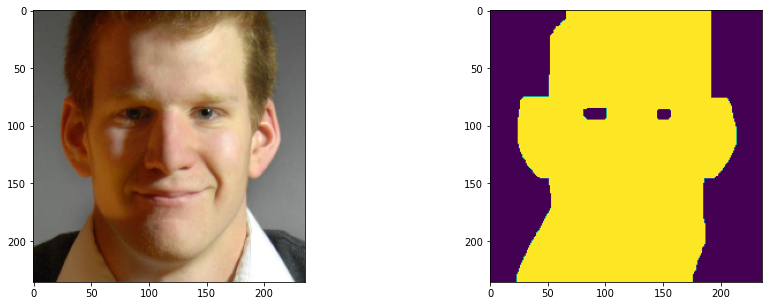

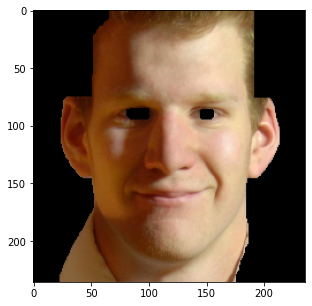

In [64]:
#grabcut as image segmentation application - applied from lab 8
def grabcut(img):
  plt.rcParams['figure.figsize'] = [15, 5]

  flat = np.reshape(img, (-1, 3))
  #Gaussians model to describe the colours of the foreground object
  fg_gmm = GaussianMixture(3)
  #Gaussians model to describe the colours of the background object
  bg_gmm = GaussianMixture(5)

  fg_mask = create_fg_mask(img)
  #background mask is inverse of the foreground
  bg_mask = fg_mask == False


  #smoothness weights
  smoothness_weight = 20
  for i in range(5):
    #reshaping image mask - and assinging to gaussian mixture
    fg_gmm.fit(np.reshape(img[fg_mask], (-1, 3)))
    bg_gmm.fit(np.reshape(img[bg_mask], (-1, 3)))


    #assinging to new variable, while reshaping again
    fg_lp = np.reshape(fg_gmm.score_samples(flat), img.shape[0:2])
    bg_lp = np.reshape(bg_gmm.score_samples(flat), img.shape[0:2])


    g = maxflow.Graph[float](0, 0)
    nodes = g.add_grid_nodes(img.shape[0:2])

    #adding edges based on smoothness weight
    g.add_grid_edges(nodes, smoothness_weight)

    g.add_grid_tedges(nodes, -fg_lp, -bg_lp)
    g.maxflow()

    sgm = g.get_grid_segments(nodes)

    fg_mask = sgm
    bg_mask = sgm == False


    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(sgm*1)
    plt.show()

  return fg_mask


fg_mask = grabcut(ex_img[0])

plt.imshow(np.expand_dims(fg_mask, axis=-1)*ex_img[0])
plt.show()

## Testing

### ORB an Brief testing

In [ ]:
#first attempt at orb
def initiate_orb(img,pts):

  for i in range(len(img)):
    orb = cv2.ORB_create()

    kp1 = (cv2.KeyPoint(pts))
    kp2 = (cv2.KeyPoint(pts)) 

    des_new = orb.compute(imgs, [kp1, kp2])
    orb_img = cv2.drawKeypoints(img,des_new,outImage = None, color=(0,255,0), flags=0)


  return orb_img

In [ ]:
#attempt to create brief features
def brief_feature(imgs, pts):

  features = []
  for i in range(len(imgs)):

    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    kp1 = cv2.KeyPoint(train_pts)
    kp2 = cv2.KeyPoint(train_pts)
    des_new = brief.compute(imgs[i], [kp, kp2])

In [ ]:
#attempt to create own keypoints
grid = []
for i in range(len(train_pts)):
  for j in range(len(train_pts)):
    kp = (i,j)
    grid.append(kp)


orb_kp = cv2.KeyPoint(grid)

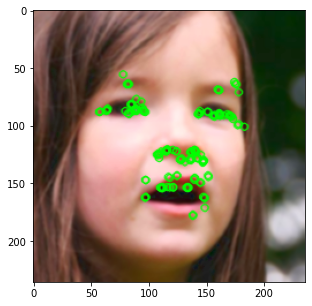

(<matplotlib.image.AxesImage at 0x7f01657c3e90>, None)

In [240]:
#orb for single image
orb = cv2.ORB_create()

kp = orb.detect(bright_train_1[5],None)

kp, des = orb.compute(bright_train_1[5], kp)

orb_img = cv2.drawKeypoints(bright_train_1[5], kp, None, color=(0,255,0), flags=0)
plt.imshow(orb_img), plt.show()

In [ ]:
#alternative descriptor function
def descriptorsq(img):
  des_list = []
  kp = orb.detect(img,None)

  kp, des = orb.compute(img, kp)

  img_kp = np.zeros_like(img)
  cv2.drawKeypoints(img, kp, img_kp, flags=4)

  print(img_kp.shape)
  des_list.append(img_kp)

  orb_des =  np.array(des_list, dtype=object)

  return orb_des

In [ ]:
#another way to print the shape of the descriptions
descriptions_list=[]
for i in bright_train_1:
  descriptions_list.append(descriptors(i))
 
descriptions_arr = np.array([np.array(j) for j in descriptions_list])
print(descriptions_arr.shape)

In [ ]:
#sift ideas - was given up in favour of orb
sift = cv2.SIFT_create()

kp_l, des_r =sift.detectAndCompute(img_gray,None)

def draw_im_kps(img, kps):
  assert(img.shape[-1] == 3)
  img_kp = np.zeros_like(img)
  cv2.drawKeypoints(img, kps, img_kp, flags=4)
  plt.imshow(img_kp)
  plt.axis('off')
  plt.show()

draw_im_kps(img_gray, kp_l)


### Histogram implementation

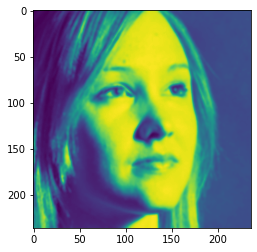

In [29]:
#testing with histogram stuff - different ideas that didn't work out
img_gray = np.uint8(np.mean(smooth_img, axis=-1))
plt.imshow(img_gray)

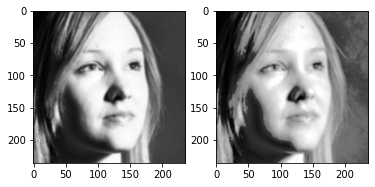

In [30]:
#histogram equalisation
img_gray_eq = cv2.equalizeHist(img_gray)
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_gray_eq, cmap='gray')
plt.show()

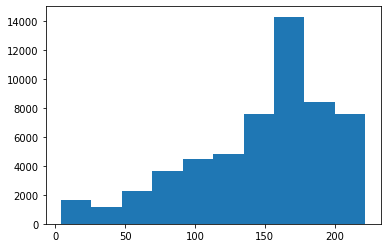

Text(0.5, 1.0, '50 bins')

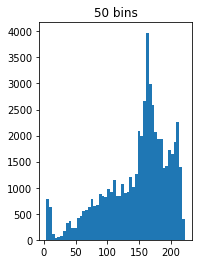

In [ ]:
#plotting histogram
img1_hist = img_gray.flatten()

plt.hist(img1_hist)
plt.show()

#Plotting Histogram for our test image
plt.subplot(1,2,1)
plt.hist(img1_hist, bins=50)
plt.title('50 bins')

In [ ]:
#Histogram Equalisation - additional equalisation
img1_eq = cv2.equalizeHist(smooth_img)
plt.subplot(1,2,1)
plt.imshow(smooth_img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img1_eq, cmap='gray')
plt.show()

In [ ]:
#aim to use lab code to segment image for extension task
from sklearn.cluster import KMeans
import cv2

def draw_segmentation(_img, seg):
  plt.rcParams['figure.figsize'] = [15, 5]
  # The number of clusters is the highest label value
  n_clusters = np.max(seg)+1
  # Create. a colour for each cluster
  colours = np.random.rand(*(n_clusters, 3))


  plt.subplot(131)
  plt.imshow(_img)
  plt.subplot(132)

  # Create an image of zeros
  seg_im = np.zeros((seg.shape[0],3), dtype=np.uint8)
  flat = np.reshape(_img, (-1, 3))
  # For each cluster, plot them in a scatter plot and fill in the seg_im
  for i in range(n_clusters):
    # Plot the red vs blue components in a scatter
    plt.plot(flat[seg==i,0], flat[seg==i,2], '+', color=colours[i,:])
    # Set the regions with a particular label to have the same colour
    seg_im[seg==i,:] = np.uint8(colours[i,:]*255)
  
  plt.xlabel('red')
  plt.ylabel('blue')
  plt.axis('equal')

  plt.subplot(133)
  
  plt.imshow(np.reshape(seg_im, _img.shape))
  plt.show()

def seg_im(_img, n_clusters=2):
  # !Insert some code to create a kmeans object here!
  flat = np.reshape(_img,(-1,3))
  kmeans = KMeans(n_clusters,random_state=0).fit(flat)

  # The segmentation labels based on the colour are given in kmeans.labels_
  seg =kmeans.labels_
  # Let's plot them using the function above
  draw_segmentation(_img, seg)
  

seg_im(img_cat1, 5)




#flat = np.reshape(_img,(-1,2))
#kmeans = KMeans(n_clusters).fit(flat)

#seg =np.reshape(kmeans.labels_,_img.shape)

#draw_segmentation(_img, seg)
  

#seg_im(img_cat1, 5)

In [ ]:
seg = cv2.FillPoly(img_gray, polys, color, lineType=8, shift=0)

### Image segmentation

In [32]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [33]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

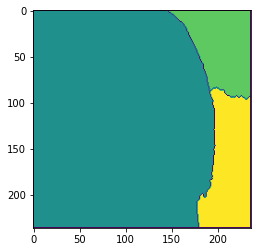

In [35]:
markers = cv2.watershed(smooth_img,markers)
smooth_img[markers == -2] = [255,0,0]
plt.imshow(markers)

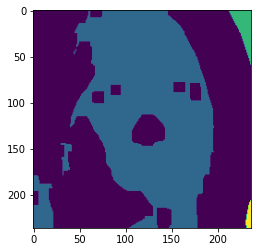

In [34]:
plt.imshow(markers)

In [31]:
#Image Segmentation through Watershed Alg
ret, thresh = cv2.threshold(img_gray_eq,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

### Image Resizing

In [9]:
resized_train = []
for i in range(len(train_img)):
  resized_train.append(cv2.resize(train_img[i], (train_img.shape[0] // 5, train_img.shape[0] // 5), interpolation=cv2.INTER_AREA))
resized_train_1 = np.array(resized_train)
resized_train_1.shape

(2811, 562, 562, 3)

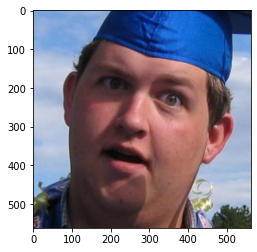

In [10]:
plt.imshow(resized_train_1[np.random.randint(0, resized_train_1.shape[0]),...])
plt.show()

In [11]:
resized_test = []
for i in range(len(test_img)):
  resized_test.append(cv2.resize(test_img[i], (test_img.shape[0] // 1, test_img.shape[0] // 1), interpolation=cv2.INTER_AREA))
resized_test_1 = np.array(resized_test)
resized_test_1.shape  

(554, 554, 554, 3)

In [13]:
resized_ex = []
for i in range(len(ex_img)):
  resized_ex.append(cv2.resize(test_img[i], (test_img.shape[0] // 1, test_img.shape[0] // 1), interpolation=cv2.INTER_AREA))
resized_ex_1 = np.array(resized_ex)
resized_ex_1.shape

(6, 554, 554, 3)

### cnn experiment

In [36]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
def make_generator(z_size=32, layer_sizes=[256, 128, 64]):

  inputs = keras.Input(shape=(z_size,), name="z")
  net = inputs

  net = layers.Dense(7*7*layer_sizes[0],use_bias=False)(net)


  net = layers.Reshape((7,7,layer_sizes[0]))(net)

  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)

  net = layers.Conv2D(layer_sizes[1], 5, padding='same', use_bias=False)(net)
  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)


  net = layers.UpSampling2D(size=(2,2))(net)

  net = layers.Conv2D(layer_sizes[2], 5, padding='same', use_bias=False)(net)
  net = layers.BatchNormalization(scale=False, center=False)(net)
  net = layers.LeakyReLU()(net)

  net = layers.UpSampling2D(size=(2,2))(net)


  net = layers.Conv2D(1, 5, padding='same', activation='sigmoid')(net)
  

  return keras.Model(inputs=inputs, outputs=net)

make_generator()

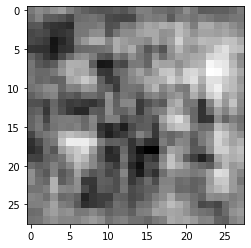

In [37]:
noise_dim = 64

generator = make_generator(z_size=noise_dim, layer_sizes=[256, 128, 64])

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(np.squeeze(generated_image[0]), cmap='gray')

In [42]:
def augment_x(data,data1):
  # We need to add a column of ones to x to describe the constant intecept
  augmented_data = np.concatenate([generated_image, bright_train_1], axis=1)
  return augmented_data
  augmented_data.shape

In [68]:
train_pts.shape

(2811, 46, 2)

In [69]:
bright_train_1.shape

(2811, 236, 236, 3)

### Colour Conversion

Aim to change colour - also deemed useless throughout investigation

In [137]:
colour_train = []
for i in range(len(train_img)):
  colour_train.append(cv2.cvtColor(train_img[i], cv2.COLOR_BGR2RGB))
colour_train_1 = np.array(colour_train)
colour_train_1.shape

(2811, 236, 236, 3)

In [ ]:
plt.imshow(colour_train_1[np.random.randint(0, colour_train_1.shape[0]),...])
plt.show()

In [ ]:
colour_test = []
for i in range(len(train_img)):
  colour_test.append(cv2.cvtColor(test_img[i], cv2.COLOR_BGR2RGB))
colour_test_1 = np.array(colour_test)
colour_test_1.shape

In [ ]:
colour_ex = []
for i in range(len(train_img)):
  colour_ex.append(cv2.cvtColor(ex_img[i], cv2.COLOR_BGR2RGB))
colour_ex_1 = np.array(colour_ex)
colour_ex_1.shape

In [ ]:
def augment_x(data):
  # We need to add a column of ones to x to describe the constant intecept
  augmented_data = np.concatenate([np.ones((data.shape[0],1)), data], axis=1)
  return augmented_data

### Test ex application

In [45]:
ex_set2 = ex_fl_img.reshape([6, 236, 236, 3])
ex_pred_set2 = ex_pred2.reshape(6,46,2)

In [241]:
#visulaising points for not pre processed data
def visualise_ex_pts2(img, pts):
  print(img.shape, pts.shape)
  plt.imshow(img[0:])
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  #plt.plot(pred_pts2[:, 0], pred_pts2[:, 1], '+b',label='predicted points')
  plt.legend()
  plt.show()

idex = np.random.randint(0, ex_set2.shape[0])
#visualise_ex_pts1(ex_set1[idex],ex_pred_set1[idex])

In [ ]:
for i in range(ex_img.shape[0]):
    visualise_ex_pts2(ex_set2[i], ex_pred_set2[i])

### Moustache Filter

In [204]:
def moustache_filter(img, pts):
    x = (int(pts[30][0]-3), int(pts[30][1]-3))
    y = (int(pts[10][0]+3), int(pts[10][1]+3))
    img = cv2.rectangle(img, x, y, (0,0,0), -2)
    plt.imshow(img)
    plt.show()

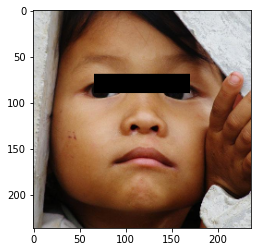

In [200]:
moustache_filter(train_set[359], pred_set[359])

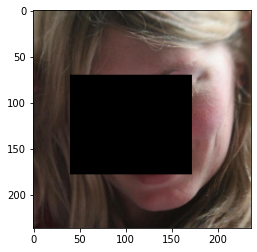

In [196]:
moustache_filter(train_set[363], pred_set[363])

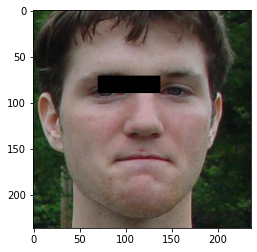

In [144]:
moustache_filter(train_set[415], pred_set[415])

### Extension testing

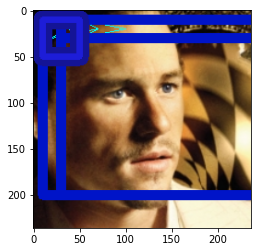

In [53]:
filter_img = train_img[10]
plt.imshow(filter_img)
filterpts = np.array([[20,5],[50,30],[100,20],[50,10]], np.int32)
filtpts = filterpts.reshape((-1,1,2))
testfilt = cv2.rectangle(filter_img,(10, 10), (50, 50), colour = #000fbc, 5)
plt.imshow(testfilt)